## PSD of BaroData

In [1]:
import matplotlib.pyplot as plt
import os

from obspy import UTCDateTime, read, Stream, Trace, read_inventory
from obspy import read_inventory

from andbro__read_sds import __read_sds
from andbro__load_FURT_stream import __load_furt_stream

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# tbeg, tend = UTCDateTime("2023-09-03"), UTCDateTime("2023-09-07")
tbeg, tend = UTCDateTime("2023-11-10"), UTCDateTime("2023-11-20")

path_to_figs = root_path+"Documents/ROMY/ROMY_infrasound/figures/"

# FFBI DATA

2 Trace(s) in Stream:
BW.FFBI..BDF | 2023-11-10T00:00:00.005000Z - 2023-11-20T00:00:00.005000Z | 40.0 Hz, 34560001 samples
BW.FFBI..BDO | 2023-11-10T00:00:00.005000Z - 2023-11-20T00:00:00.005000Z | 40.0 Hz, 34560001 samples


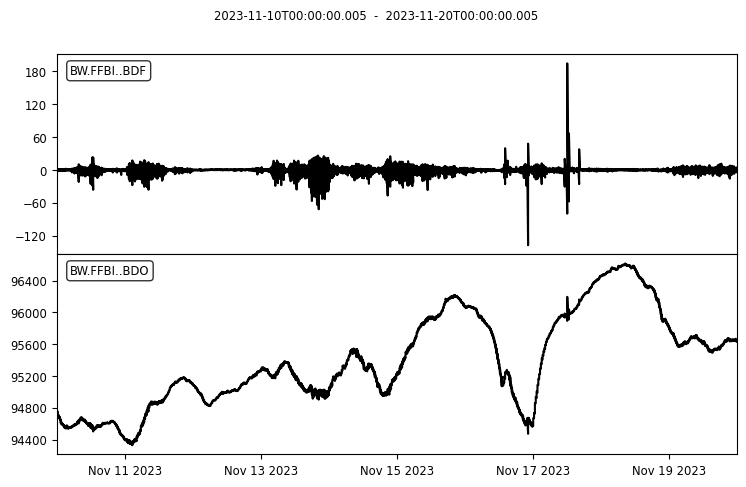

In [4]:

## period to check data... one sided differential signals...
# tbeg, tend = "2023-08-13","2023-08-20"
# ffbi = __read_sds("/import/kilauea-data/LNM2/mb2000/sds/", "BW.IROMY..BD*", tbeg, tend)

ffbi = __read_sds(root_path+"/bay200/mseed_online/archive/", "BW.FFBI..BD*", tbeg, tend)
# ffbi = __read_sds("/home/andbro/bay200/", "BW.FFBI..BD*", tbeg, tend)

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")

if len(ffbi) != 2:
    ffbi.merge();

# ffbi = ffbi.remove_response(ffbi_inv)

## remove gain and sensitivity
for tr in ffbi:
    if "F" in tr.stats.channel:
        # tr = tr.remove_response(ffbi_inv)
        tr.data = tr.data *1.589e-6 /0.02  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005=0.02 VPa
    elif "O" in tr.stats.channel:
        tr.data = tr.data *1.589e-6 *1e5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 1 mV/hPa

ffbi.merge();

print(ffbi)

ffbi.plot(equal_scale=False);

## PROMY Data

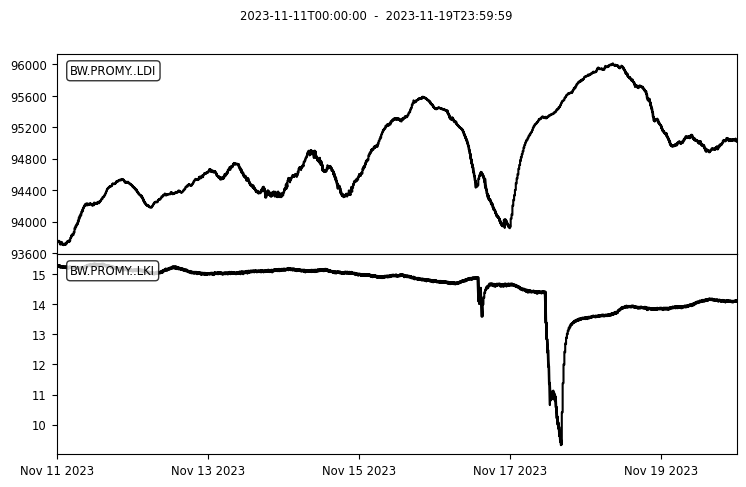

In [5]:
promy = __read_sds(archive_path+"romy_archive/", "BW.PROMY..L*", tbeg, tend)
promy.merge();
promy.plot(equal_scale=False);

## Compare PROMY and MB2005

In [6]:
mb2005 = ffbi.trim(UTCDateTime("2023-11-11"), UTCDateTime("2023-11-20"))
mb2005.resample(1.0)

dps310 = promy.trim(UTCDateTime("2023-11-11"), UTCDateTime("2023-11-20"))

In [7]:
mb2005, dps310

(2 Trace(s) in Stream:
BW.FFBI..BDF | 2023-11-11T00:00:00.005000Z - 2023-11-19T23:59:59.005000Z | 1.0 Hz, 777600 samples
BW.FFBI..BDO | 2023-11-11T00:00:00.005000Z - 2023-11-19T23:59:59.005000Z | 1.0 Hz, 777600 samples,
 2 Trace(s) in Stream:
BW.PROMY..LDI | 2023-11-11T00:00:00.000000Z - 2023-11-19T23:59:59.000000Z | 1.0 Hz, 777600 samples
BW.PROMY..LKI | 2023-11-11T00:00:00.000000Z - 2023-11-19T23:59:59.000000Z | 1.0 Hz, 777600 samples)

In [8]:
p_diff = mb2005.select(channel="BDO")[0].data - dps310.select(channel="LDI")[0].data

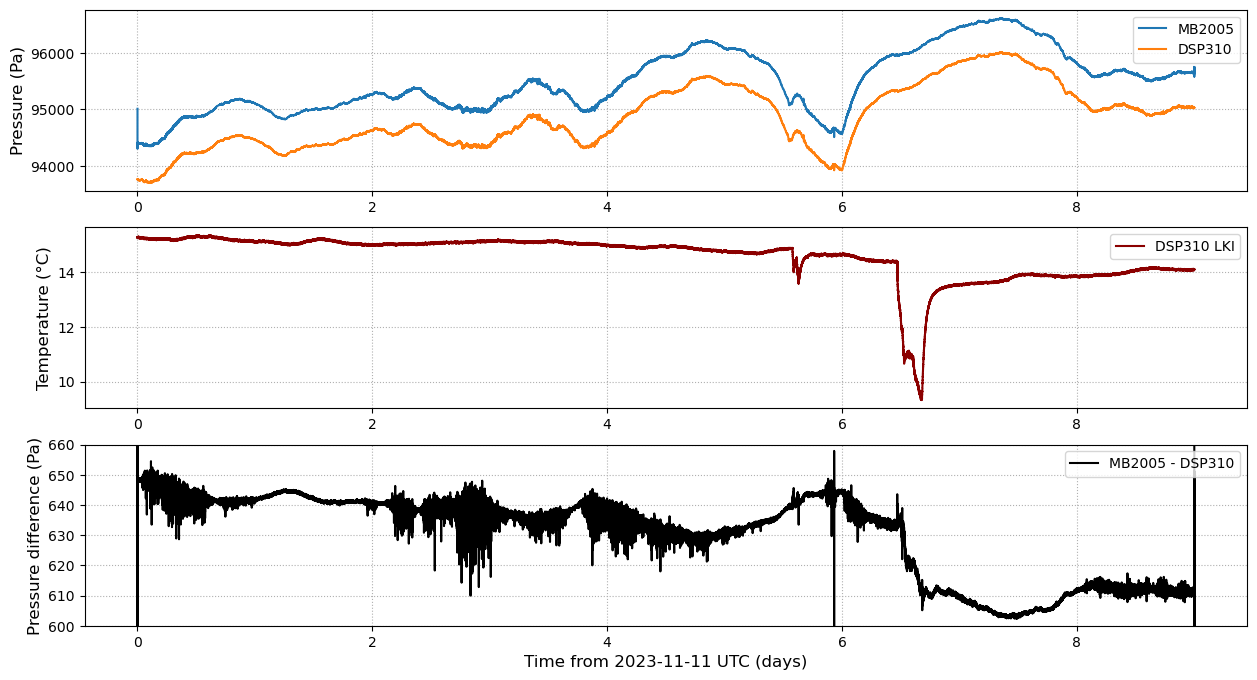

In [9]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    t_axis = mb2005.select(channel="BDO")[0].times()/86400

    ax[0].plot(t_axis, mb2005.select(channel="BDO")[0].data, zorder=2, label="MB2005")
    ax[0].plot(t_axis, dps310.select(channel="LDI")[0].data, zorder=2, label="DSP310")

    ax[1].plot(t_axis, dps310.select(channel="LKI")[0].data, color="darkred", zorder=2, label="DSP310 LKI")

    ax[2].plot(t_axis, p_diff, color="black", zorder=2, label="MB2005 - DSP310")
    ax[2].set_ylim(600, 660)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylabel(f"Pressure (Pa)", fontsize=font)
    ax[1].set_ylabel(f"Temperature (°C)", fontsize=font)
    ax[2].set_ylabel(f"Pressure difference (Pa)", fontsize=font)
    ax[2].set_xlabel(f"Time from {mb2005[0].stats.starttime.date} UTC (days)", fontsize=font)

    plt.show();
    return fig


fig = __makeplot();

fig.savefig(path_to_figs+f"Compare_MB2005_DPS310_timeseries.png", format="png", dpi=200, bbox_inches='tight')

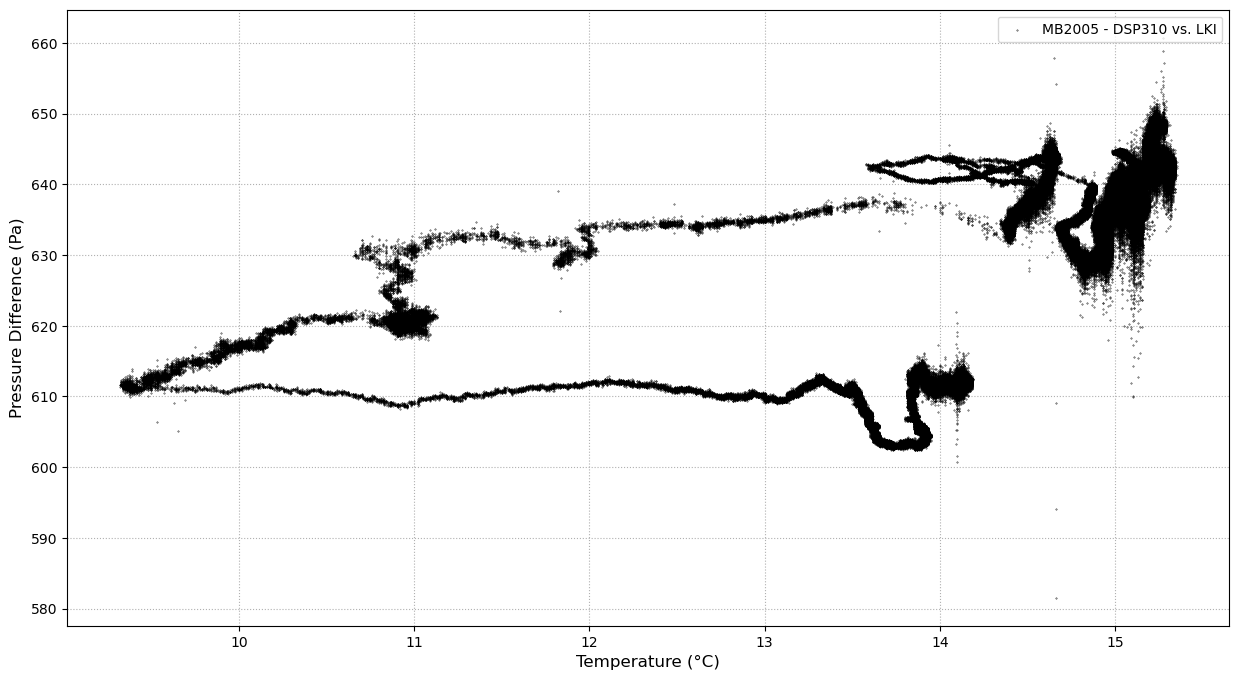

In [10]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    t_axis = mb2005.select(channel="BDO")[0].times()/86400

    ax.scatter(dps310.select(channel="LKI")[0].data[10:-10], p_diff[10:-10], color="black", s=.1, zorder=2, label="MB2005 - DSP310 vs. LKI")


    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)

    ax.set_xlabel(f"Temperature (°C)", fontsize=font)
    ax.set_ylabel(f"Pressure Difference (Pa)", fontsize=font)

    plt.show();
    return fig


fig = __makeplot();

fig.savefig(path_to_figs+f"Compare_MB2005_DPS310_pressure_difference_vs_temperature.png", format="png", dpi=200, bbox_inches='tight')

In [11]:
def __multitaper_psd(arr, dt, n_win=5):

    import multitaper as mt

    out_psd = mt.MTSpec(arr, nw=n_win, kspec=0, dt=dt)

    _f, _psd = out_psd.rspec()

    f = _f.reshape(_f.size)
    psd = _psd.reshape(_psd.size)

    ## 95% confidence interval
    # _psd95 = out_psd.jackspec()
    # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

    return f, psd

In [12]:
# f_mb2005, psd_mb2005 = __multitaper_psd(mb2005.select(channel="BDO")[0].data, 
#                                         mb2005.select(channel="BDO")[0].stats.delta,
#                                         n_win=5
#                                        )

In [13]:
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="density",
                    return_onesided=True)

    return ff, Pxx

In [14]:
f_mb2005, psd_mb2005 = __welch_psd(mb2005.select(channel="BDO")[0].data[10:-10],
                                   mb2005.select(channel="BDO")[0].stats.delta,
                                   twin_sec=10800,
                                   )

f_dps310, psd_dps310 = __welch_psd(dps310.select(channel="LDI")[0].data[10:-10],
                                     dps310.select(channel="LDI")[0].stats.delta,
                                     twin_sec=10800,
                                     )

In [15]:
from scipy.signal import coherence

df = dps310.select(channel="LDI")[0].stats.sampling_rate
nperseg = int(10800 * df)
noverlap = int(0.5*nperseg)

f_coh, coh = coherence(mb2005.select(channel="BDO")[0].data[10:-10],
                       dps310.select(channel="LDI")[0].data[10:-10],
                       fs = df, nperseg=nperseg, noverlap=noverlap)

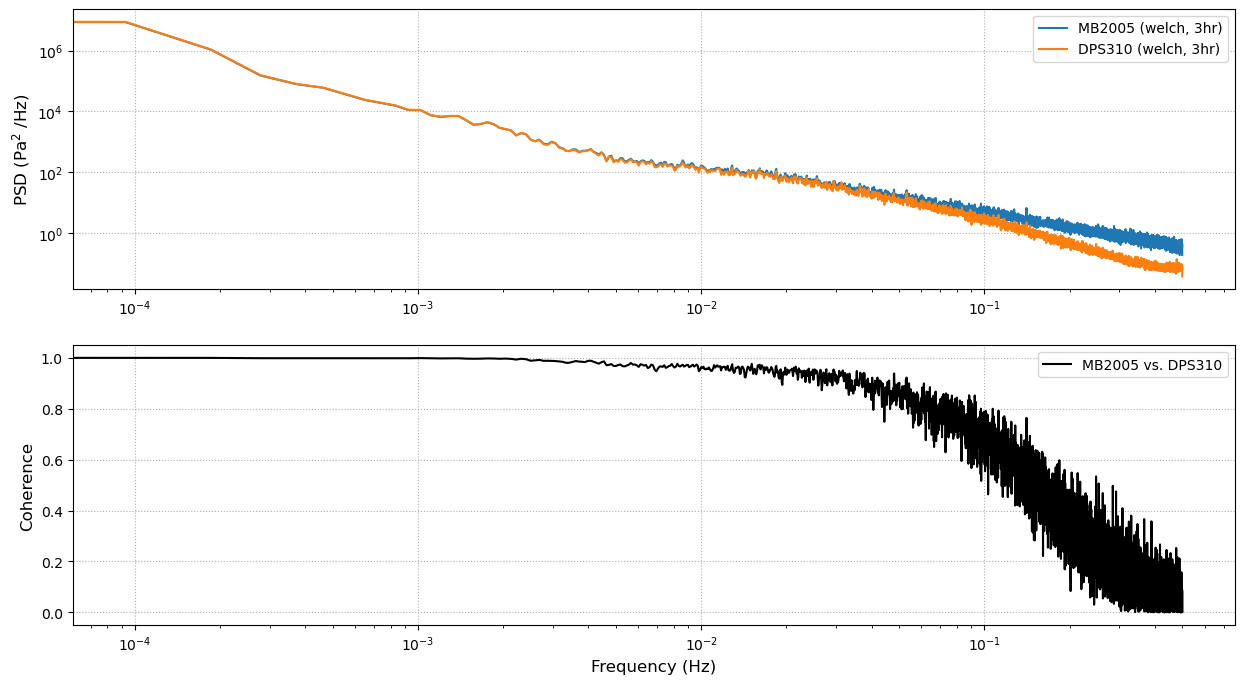

In [16]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].loglog(f_mb2005, psd_mb2005, label="MB2005 (welch, 3hr)")
    ax[0].loglog(f_dps310, psd_dps310, label="DPS310 (welch, 3hr)")

    ax[1].semilogx(f_coh, coh, color="k", label="MB2005 vs. DPS310")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)


    ax[0].set_ylabel("PSD (Pa$^2$ /Hz)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel("Coherence", fontsize=font)

    plt.show();
    return fig


fig = __makeplot();

fig.savefig(path_to_figs+f"Compare_MB2005_DPS310_PSD_Coherence.png", format="png", dpi=200, bbox_inches='tight')